# Setup

In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import typing
import joblib
import json

from interpret.ext.glassbox import LGBMExplainableModel
from interpret_community.common.base_explainer import BaseExplainer

from azureml.core import Environment, Workspace
from azureml.core.compute.aks import AksCompute
from azureml.core.dataset import Dataset
from azureml.core.datastore import Datastore
from azureml.core.environment import CondaDependencies
from azureml.core.experiment import Experiment
from azureml.core.model import InferenceConfig, Model
from azureml.core.run import Run
from azureml.core.webservice import LocalWebservice, AksWebservice, Webservice
from azureml.data.azure_storage_datastore import AzureBlobDatastore

from azureml.interpret import ExplanationClient
from azureml.interpret.mimic_wrapper import MimicWrapper
from azureml.interpret.scoring.scoring_explainer import ScoringExplainer, TreeScoringExplainer

from azureml.train.automl.runtime.automl_explain_utilities import automl_setup_model_explanations
from azureml.train.automl.runtime.automl_explain_utilities import AutoMLExplainerSetupClass

from azureml.automl.runtime.streaming_pipeline_wrapper import StreamingPipelineWrapper

# Register Model

In [3]:
# Custom function to register model
def register_model(ws: Workspace, fitted_model: Model, model_name: str, model_path: str):
    joblib.dump(fitted_model, model_path)
    
# Custom function to get experiment's run
def get_exp_run(ws: Workspace, experiment_name: str):
    experiment = Experiment(ws, experiment_name)
    for run in experiment.get_runs():
        if run.status == 'Completed':
            return run

In [4]:
# Get the latest successful experiments' run
car_price_best_run, car_price_fitted_model = get_exp_run(ws, 'automl-car-price-prediction').get_output()
car_demand_best_run, car_demand_fitted_model = get_exp_run(ws, 'automl-car-demand-forecasting').get_output()

# Register models (Uncomment this to run for the first time)
# register_model(ws, car_price_fitted_model, 'car_price_model', 'car_price_model.sav')
# register_model(ws, car_price_fitted_model, 'car_demand_model', 'car_demand_model.sav')

# Retrieve models
car_price_model = Model(ws, name='car_price_model')
car_demand_model = Model(ws, name='car_demand_model')

In [5]:
class DeploymentSetup():
    def __init__(self, ws: Workspace, task: str, train_dataset:str, test_dataset:str, label_column_name: str, 
                 fitted_model: typing.Union[Pipeline, StreamingPipelineWrapper], best_run: Run, blob_ds=get_blobstore()):
        self.ws = ws
        self.blob_ds = blob_ds
        self.task = task
        self.fitted_model = fitted_model
        self.best_run = best_run
        self.label_column_name = label_column_name
        # Get data for explainer
        self.train_dataset = Dataset.get_by_name(ws, train_dataset)
        self.test_dataset = Dataset.get_by_name(ws, test_dataset)
        self.X_train = self.train_dataset.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
        self.y_train = self.train_dataset.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()
        self.X_test = self.test_dataset.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
        self.y_test = self.test_dataset.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()
    
    def init_mimic_explainer(self):
        # Setup the explainer for the trained ML models
        explainer_setup = automl_setup_model_explanations(self.fitted_model, 
                                                          X=self.X_train, 
                                                          X_test=self.X_test, 
                                                          y=self.y_train, 
                                                          task=self.task)
        
        # Define parameters for the mimic wrapper
        mimic_wrapper_params = {
            'workspace': self.ws,
            'model': explainer_setup.automl_estimator,
            'explainable_model': explainer_setup.surrogate_model,
            'init_dataset': explainer_setup.X_transform, 
            'run': self.best_run,
            'features': explainer_setup.engineered_feature_names,
            'feature_maps': [explainer_setup.feature_map],
            'classes': explainer_setup.classes, 
            'explainer_kwargs': explainer_setup.surrogate_model_params,
        }

        # Compute feature importance
        explainer = MimicWrapper(**mimic_wrapper_params)
        self.explainer = explainer
        self.explainer_setup = explainer_setup
        
        return self.explainer
    
    def upload_global_feature_importance(self, folder_name: str):
        best_run = self.best_run
        explainer = self.explainer
        setup = self.explainer_setup
        
        # Upload global engineered feature importance
        engineered_explanation = self.explainer.explain(explanation_types='global', 
                                                        eval_dataset=setup.X_test_transform)

        # Upload global raw feature importance
        raw_explanation = self.explainer.explain(explanation_types='global', 
                                                 eval_dataset=setup.X_test_transform,
                                                 get_raw=True,
                                                 raw_feature_names=setup.raw_feature_names,
                                                 raw_eval_dataset=setup.X_test_raw)

        # Convert to dictionaries for conversion to JSON later
        raw_feature_importance = raw_explanation.get_feature_importance_dict()
        engineered_feature_importance = engineered_explanation.get_feature_importance_dict()

        RAW_JSON_FILE = 'global_raw_feature_importance.json'
        ENGINEERED_JSON_FILE = 'global_engineered_feature_importance.json'

        with open(RAW_JSON_FILE, 'w') as f:
            json.dump(raw_feature_importance, f)

        with open(ENGINEERED_JSON_FILE, 'w') as f:
            json.dump(engineered_feature_importance, f)

        # Save global feature importances for faster retrieval when needed by web service later
        files = [RAW_JSON_FILE, ENGINEERED_JSON_FILE]
        self.blob_ds.upload_files(files, target_path=f'./feature_importance/{folder_name}', overwrite=True)

        RUN_ID = best_run.id
        EXPERIMENT_NAME = best_run.experiment.name

        print(f'Uploaded {RAW_JSON_FILE} and {ENGINEERED_JSON_FILE} '+ 
              f'to feature_importance/{folder_name} in {self.blob_ds.container_name}')
    
    def register_explainer(self, model_name: str):
        ws = self.ws
        setup = self.explainer_setup
        best_run = self.best_run
        
        # Define scoring model for approximating feature importance values
        # This scoring model is used for explaining unforeseen data predicted by the fitted model
        scoring_explainer = TreeScoringExplainer(self.explainer.explainer, feature_maps=[setup.feature_map])

        # Save the scoring model into the output folder of the best experiment run
        model_file = f'{model_name}.pkl'
        with open(model_file, 'wb') as f:
            joblib.dump(scoring_explainer, f)

        # Save scoring explainer to datastore
        self.blob_ds.upload_files([model_file], target_path='./scoring_explainer', overwrite=True)
        
        print(f'Uploaded {model_file} to scoring_explainer/ in {self.blob_ds.container_name}')

        # Register the explainer model to be used as a web service later
        explainer = Model.register(ws, f'{model_name}.pkl', model_name)

        print(f'Registered {model_name}.')

In [6]:
# Configuration for each automl tasks
car_dealership_automl_configurations = [
    {
        'ws': ws,
        'task' : 'regression',
        'label_column_name' : 'price',
        'train_dataset' : 'car_train',
        'test_dataset' : 'car_test',
        'fitted_model': car_price_fitted_model,
        'best_run': car_price_best_run,
    },
    {
        'ws': ws,
        'task' : 'forecasting',
        'label_column_name' : 'sales_amount',
        'train_dataset' : 'car_demand_train',
        'test_dataset' : 'car_demand_test',
        'fitted_model': car_demand_fitted_model,
        'best_run': car_demand_best_run,
    },
]

# Initialize deployment setup
car_price_deployment_setup = DeploymentSetup(**car_dealership_automl_configurations[0])
# Intialize mimic explainer
car_price_deployment_setup.init_mimic_explainer()
# Upload global feature importance for fast retrieval by the web service later
car_price_deployment_setup.upload_global_feature_importance(folder_name='car_price')
# Register explainer to explain predictions on unforseen data
car_price_deployment_setup.register_explainer(model_name='car_price_scoring_explainer')

Current status: Setting up data for AutoML explanations
Current status: Setting up the AutoML featurizer
Current status: Setting up the AutoML estimator
Current status: Setting up the AutoML featurization for explanations
Current status: Using 1094 evaluation samples
Current status: Generating a feature map for raw feature importance
Current status: Choosing the surrogate model as LightGBM for the AutoML model
Current status: Data for AutoML explanations successfully setup


INFO:interpret_community.common.explanation_utils:Using default datastore for uploads
INFO:interpret_community.common.explanation_utils:Using default datastore for uploads


Uploading an estimated of 2 files
Uploading global_raw_feature_importance.json
Uploading global_engineered_feature_importance.json
Uploaded 0 files
Uploaded global_raw_feature_importance.json and global_engineered_feature_importance.json to feature_importance/car_price in modeldata


--- Logging error ---
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/data/azure_storage_datastore.py", line 332, in handler
    result = future.result()
  File "/anaconda/envs/azureml_py36/lib/python3.6/concurrent/futures/_base.py", line 425, in result
    return self.__get_result()
  File "/anaconda/envs/azureml_py36/lib/python3.6/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
  File "/anaconda/envs/azureml_py36/lib/python3.6/concurrent/futures/thread.py", line 56, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/data/azure_storage_datastore.py", line 787, in <lambda>
    lambda target, source: lambda: self.blob_service.create_blob_from_path(self.container_name, target, source)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/_vendor/azure_storage/blob/blockblobservice.py", line 463, in creat

Uploading an estimated of 1 files
Uploading car_price_scoring_explainer.pkl
Uploaded 0 files
Uploaded car_price_scoring_explainer.pkl to scoring_explainer/ in modeldata


--- Logging error ---
Traceback (most recent call last):
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/data/azure_storage_datastore.py", line 332, in handler
    result = future.result()
  File "/anaconda/envs/azureml_py36/lib/python3.6/concurrent/futures/_base.py", line 425, in result
    return self.__get_result()
  File "/anaconda/envs/azureml_py36/lib/python3.6/concurrent/futures/_base.py", line 384, in __get_result
    raise self._exception
  File "/anaconda/envs/azureml_py36/lib/python3.6/concurrent/futures/thread.py", line 56, in run
    result = self.fn(*self.args, **self.kwargs)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/data/azure_storage_datastore.py", line 787, in <lambda>
    lambda target, source: lambda: self.blob_service.create_blob_from_path(self.container_name, target, source)
  File "/anaconda/envs/azureml_py36/lib/python3.6/site-packages/azureml/_vendor/azure_storage/blob/blockblobservice.py", line 463, in creat

Registering model car_price_scoring_explainer
Registered car_price_scoring_explainer.


# Define Entry Script
- The entry script receives data submitted to a deployed web service and passes it to the model. It then returns the model's response to the client.

In [7]:
car_price_folder = './car_price_service'

# Create a folder for the web service files
os.makedirs(car_price_folder, exist_ok=True)

# Set path for scoring script
car_price_script_file = 'score_car_price.py'
car_price_script_file_path = os.path.join(car_price_folder, car_price_script_file)

In [8]:
%%writefile $car_price_script_file_path
import numpy as np
import pandas as pd
import json
import joblib

from azureml.core.model import Model
from azureml.train.automl.runtime.automl_explain_utilities import automl_setup_model_explanations

# Called when the service is loaded
def init():
    global model, explainer
    # Get the path to the registered model file and load it
    model_path = Model.get_model_path('car_price_model')
    model = joblib.load(model_path)
    # Get the path to the registered scoring explainer file and load it
    explainer_path = Model.get_model_path('car_price_scoring_explainer')
    explainer = joblib.load(explainer_path)
    
# Called when a request is received
def run(raw_data):
    # Convert json to dataframe
    data = pd.read_json(raw_data, orient='records')
    # Perform prediction
    predictions = model.predict(data)
    # Setup for inferencing explanations
    explainer_setup = automl_setup_model_explanations(model, 
                                                      X_test=data,  
                                                      task='regression')
    # Retrieve model explanations for engineered explanations
    engineered_local_feature_importance = explainer.explain(explainer_setup.X_test_transform, 
                                                            get_raw=False)
    # Retrieve model explanations for raw explanations
    raw_local_feature_importance = explainer.explain(explainer_setup.X_test_transform, 
                                                     get_raw=True)
    
    # Serialize to json
    return {
        'predictions': predictions.tolist(), 
        'raw_feature_names': explainer_setup.raw_feature_names,
        'engineered_feature_names': explainer_setup.engineered_feature_names,
        'raw_local_feature_importance': raw_local_feature_importance, 
        'engineered_local_feature_importance': engineered_local_feature_importance,
    }

Overwriting ./car_price_service/score_car_price.py


# Define Inference Configuration
- An inference configuration describes the Docker container and files to use when initializing your web service.
- The inference configuration below specifies that the machine learning deployment will use the file echo_score.py in the ./source_dir directory to process incoming requests and that it will use the Docker image with the Python packages specified in the project_environment environment.

## Define environment

**Importance**: Define consistent, reusable runtime contexts for your experiments - regardless of where the experiment script is run.

1. Get environment from local conda environment (Not recommended, most likely failed)

    `conda activate <your-environment-name>`

    `conda env export --no-builds | findstr -v "prefix" > environment.yml`

```python
env = Environment.from_conda_specification(name='training_environment',
                                           file_path='./conda.yml')
```

2. Get environment from an existing Conda environment

```python
env = Environment.from_existing_conda_environment(name='training_environment',
                                                  conda_environment_name='py_env')
```

3. Add conda packae on existing environment (Recommended)

```python
from azureml.core.environment import CondaDependencies

myenv = Environment(name="myenv")

conda_dep = CondaDependencies()

conda_dep.add_conda_package("scikit-learn")
```

Register environment by:
```python
env.register(workspace=ws)
```

Get environment by:
```python
training_env = Environment.get(workspace=ws, name='training_environment')
```

```python
# env = Environment('AzureML-sklearn-0.24.1-ubuntu18.04-py37-cpu-inference')
env = Environment('custom_car_price_env')
conda_dep = CondaDependencies.create(conda_packages=['packaging', 'numpy', 'pandas', 'scikit-learn','pip'], 
                                     pip_packages=['azureml-sdk', 'azureml-automl-runtime', 'azureml-train-automl-runtime', 
                                                   'azureml-defaults', 'azureml-monitoring', 'inference-schema[numpy-support]'])
env.python.conda_dependencies = conda_dep

print(env.python.conda_dependencies.serialize_to_string())
```

In [9]:
# env = Environment('AzureML-sklearn-0.24.1-ubuntu18.04-py37-cpu-inference')
env = Environment('custom_car_price_env')
conda_dep = CondaDependencies.create(conda_packages=['pip', 'packaging', 'numpy', 'pandas', 'scikit-learn'], 
                                     pip_packages=['azureml-defaults', 'azureml-train-automl-runtime'])
env.python.conda_dependencies = conda_dep

print(env.python.conda_dependencies.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.5.2 and later.
- python=3.6.2

- pip:
  - azureml-defaults~=1.29.0
  - azureml-train-automl-runtime~=1.29.0
- pip
- packaging
- numpy
- pandas
- scikit-learn
channels:
- anaconda
- conda-forge



In [10]:
inference_config = InferenceConfig(
    environment=env,
    source_directory=car_price_folder,
    entry_script=car_price_script_file,
)

# Define Deployment Configuration

## Compute Targets for Real-Time Inference

**Azure Kubernetes Service (AKS)**
- Real-time inference
- GPU support for web service deployment
- Use for high-scale production deployments. Provides fast response time and autoscaling of the deployed service.

**Azure Container Instances**
- No GPU support for web service deployment
- Use for low-scale CPU-based workloads that require less than 48 GB of RAM.
- Use key-based authentication to configure authentication for models deployed in Azure Container Instances. https://docs.microsoft.com/en-gb/azure/machine-learning/how-to-authenticate-web-service
- Token-based authentication is not available in Azure Container Instances
- To test the local web service from a compute instance, use the https://localhost:<local_service.port> URL.
- To test the local web service from a remote client, get the public URL of the service running on the compute instance. The public URL can be determined use the following formula;
    - Notebook VM: https://<vm_name>-<local_service_port>.<azure_region_of_workspace>.notebooks.azureml.net/score.
    - Compute instance: https://<vm_name>-<local_service_port>.<azure_region_of_workspace>.instances.azureml.net/score

In [11]:
local_deployment_config = LocalWebservice.deploy_configuration(port=6789)

# Deploy Model

## Local Deployment

Local model deployment is crucial for testing and troubleshooting purposes to ensure everything works.

In [12]:
car_price_models = [
    Model(ws, 'car_price_model'),
    Model(ws, 'car_price_scoring_explainer')
]

local_service = Model.deploy(
    ws,
    'car-price-predictions',
    car_price_models,
    inference_config,
    local_deployment_config
)

local_service.wait_for_deployment(show_output=True)

Generating Docker build context.
2021/06/07 07:58:06 Downloading source code...
2021/06/07 07:58:07 Finished downloading source code
2021/06/07 07:58:08 Creating Docker network: acb_default_network, driver: 'bridge'
2021/06/07 07:58:09 Successfully set up Docker network: acb_default_network
2021/06/07 07:58:09 Setting up Docker configuration...
2021/06/07 07:58:10 Successfully set up Docker configuration
2021/06/07 07:58:10 Logging in to registry: 52e628b0c30941528e6377d08607560b.azurecr.io
2021/06/07 07:58:11 Successfully logged into 52e628b0c30941528e6377d08607560b.azurecr.io
2021/06/07 07:58:11 Executing step ID: acb_step_0. Timeout(sec): 5400, Working directory: '', Network: 'acb_default_network'
2021/06/07 07:58:11 Scanning for dependencies...
2021/06/07 07:58:12 Successfully scanned dependencies
2021/06/07 07:58:12 Launching container with name: acb_step_0
Sending build context to Docker daemon  66.56kB
Step 1/18 : FROM mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210507.


done
#
# To activate this environment, use
#
#     $ conda activate /azureml-envs/azureml_c6951f9d4c507c5496c5b1428a988a6b
#
# To deactivate an active environment, use
#
#     $ conda deactivate



==> WARNING: A newer version of conda exists. <==
  current version: 4.9.2
  latest version: 4.10.1

Please update conda by running

    $ conda update -n base -c defaults conda


Removing intermediate container 07327178ff33
 ---> f075a8dc3cf2
Step 9/18 : ENV PATH /azureml-envs/azureml_c6951f9d4c507c5496c5b1428a988a6b/bin:$PATH
 ---> Running in fedf53e51558
Removing intermediate container fedf53e51558
 ---> 67ad2c9ce3ba
Step 10/18 : COPY azureml-environment-setup/send_conda_dependencies.py azureml-environment-setup/send_conda_dependencies.py
 ---> 89ac72158c1c
Step 11/18 : COPY azureml-environment-setup/environment_context.json azureml-environment-setup/environment_context.json
 ---> 0ad07e19f4dc
Step 12/18 : RUN python /azureml-environment-setup/send_conda_dependencies.py -p /azureml-envs/

Package creation Succeeded
Logging into Docker registry 52e628b0c30941528e6377d08607560b.azurecr.io
Logging into Docker registry 52e628b0c30941528e6377d08607560b.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM 52e628b0c30941528e6377d08607560b.azurecr.io/azureml/azureml_dc5e0adcc0ee50cfae10c538a4b7d593
 ---> 5cad2363b36c
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> 485c7d8b2d7e
Step 3/5 : RUN mkdir -p '/var/azureml-app' && echo eyJhY2NvdW50Q29udGV4dCI6eyJzdWJzY3JpcHRpb25JZCI6IjY0OGE5MDgwLWM1ZjYtNDU4Yy1iMWQxLTdjZGUzMWI5NmYzZCIsInJlc291cmNlR3JvdXBOYW1lIjoiY2FyX2RlYWxlcnNoaXAiLCJhY2NvdW50TmFtZSI6ImNhcl9kZWFsZXJzaGlwX2F6dXJlbWwiLCJ3b3Jrc3BhY2VJZCI6IjUyZTYyOGIwLWMzMDktNDE1Mi04ZTYzLTc3ZDA4NjA3NTYwYiJ9LCJtb2RlbHMiOnt9LCJtb2RlbHNJbmZvIjp7fX0= | base64 --decode > /var/azureml-app/model_config_map.json
 ---> Running in f6252db2e628
 ---> 01fbf16525d1
Step 4/5 : RUN mv '/var/azureml-app/tmpcfukmd6e.py' /var/azureml-app/main.py
 ---> Running in 036e266b0060
 ---> 5767ef78c

Testing locally deployed model.

In [13]:
import requests
import json
from azureml.core.authentication import InteractiveLoginAuthentication

# Get a token to authenticate to the compute instance from remote
interactive_auth = InteractiveLoginAuthentication()
auth_header = interactive_auth.get_authentication_header()

# Create and submit a request using the auth header
headers = auth_header
# Add content type header
headers.update({'Content-Type':'application/json'})
# Sample data to send to the service
test_sample = car_price_deployment_setup.X_test[:10].to_json(orient='records')

# Replace with the URL for your compute instance, as determined from the previous section
service_url = 'https://car-dealership-ci-6789.southeastasia.instances.azureml.net/score'
# for a compute instance, the url would be https://vm-name-6789.northcentralus.instances.azureml.net/score
resp = requests.post(service_url, test_sample, headers=headers)
print("prediction:", resp.text)

prediction: {"predictions": [76344.86638761319, 65543.2116954207, 68714.09905453265, 150885.6964828818, 46934.4910060763, 86608.93082672331, 103759.6731642273, 103453.09054467226, 72924.99340168548, 71561.90712970613], "raw_feature_names": ["product_link-href", "manufacture_year", "mileage", "length_mm", "engine_cc", "aspiration", "wheel_base_mm", "width_mm", "direct_injection", "seat_capacity", "peak_power_hp", "fuel_type", "steering_type", "assembled", "height_mm", "peak_torque_nm", "doors", "brand", "colour", "model", "tranmission"], "engineered_feature_names": ["manufacture_year_MeanImputer", "mileage_MeanImputer", "length_mm_MeanImputer", "engine_cc_MeanImputer", "wheel_base_mm_MeanImputer", "width_mm_MeanImputer", "seat_capacity_MeanImputer", "peak_power_hp_MeanImputer", "height_mm_MeanImputer", "peak_torque_nm_MeanImputer", "doors_MeanImputer", "aspiration_CharGramCountVectorizer_aspirated", "aspiration_CharGramCountVectorizer_supercharged", "aspiration_CharGramCountVectorizer_s

In [14]:
body = json.loads(resp.text)
predictions = body['predictions']
raw_feature_names = body['raw_feature_names']
engineered_feature_names = body['engineered_feature_names']
raw_local_fi = body['raw_local_feature_importance']
engineered_local_fi = body['engineered_local_feature_importance']

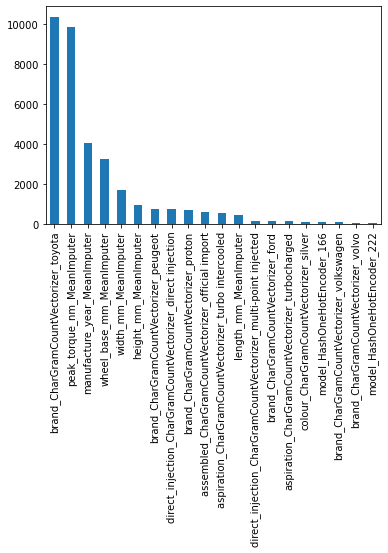

In [15]:
cols = [f'fi_{i}' for i in range(len(engineered_local_fi))]
pd_eng = pd.DataFrame(np.array(engineered_local_fi).T, index=engineered_feature_names, columns=cols)
pd_eng = pd_eng['fi_0'].sort_values(ascending=False).head(20)
pd_eng.plot.bar()

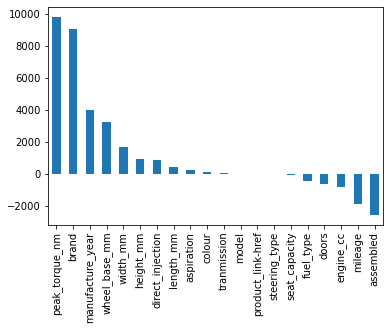

In [16]:
cols = [f'fi_{i}' for i in range(len(raw_local_fi))]
pd_raw = pd.DataFrame(np.array(raw_local_fi).T, index=raw_feature_names, columns=cols)
pd_raw = pd_raw['fi_0'].sort_values(ascending=False).head(20)
pd_raw.plot.bar()

## Azure Kubernetes Service (AKS) Deployment

In [17]:
from azureml.core.compute import ComputeTarget

# Create the cluster
aks_target = ComputeTarget(workspace = ws, name = 'car-dealership') 

# If deploying to a cluster configured for dev/test, ensure that it was created with enough
# cores and memory to handle this deployment configuration. Note that memory is also used by
# things such as dependencies and AML components.
deployment_config = AksWebservice.deploy_configuration()

remote_service = Model.deploy(ws, 
                              'car-price-web-service', 
                              car_price_models, 
                              inference_config, 
                              deployment_config, 
                              aks_target)

remote_service.wait_for_deployment(show_output = True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-06-07 08:10:59+00:00 Creating Container Registry if not exists.
2021-06-07 08:10:59+00:00 Registering the environment.
2021-06-07 08:10:59+00:00 Use the existing image.
2021-06-07 08:11:01+00:00 Creating resources in AKS.
2021-06-07 08:11:02+00:00 Submitting deployment to compute.
2021-06-07 08:11:02+00:00 Checking the status of deployment car-price-web-service..
2021-06-07 08:13:23+00:00 Checking the status of inference endpoint car-price-web-service.
Succeeded
AKS service creation operation finished, operation "Succeeded"


Testing remotely deployed model.

In [18]:
import urllib.request
import json
import os

data = car_price_deployment_setup.X_test[:10].to_json(orient='records')
body = str.encode(data)

url = 'https://car-dealershipsy41d7.southeastasia.cloudapp.azure.com:443/api/v1/service/car-price-web-service/score'
api_key = 'MHwPqJkgw4DGvw1qve4SVnCvoj36SgCG'
headers = {'Content-Type':'application/json', 'Authorization':('Bearer '+ api_key)}

req = urllib.request.Request(url, body, headers)

try:
    response = urllib.request.urlopen(req)

    result = response.read()
    print(result)
except urllib.error.HTTPError as error:
    print("The request failed with status code: " + str(error.code))

    # Print the headers - they include the requert ID and the timestamp, which are useful for debugging the failure
    print(error.info())
    print(json.loads(error.read().decode("utf8", 'ignore')))

b'{"predictions": [76344.86638761319, 65543.2116954207, 68714.09905453265, 150885.6964828818, 46934.4910060763, 86608.93082672331, 103759.6731642273, 103453.09054467226, 72924.99340168548, 71561.90712970613], "raw_feature_names": ["product_link-href", "manufacture_year", "mileage", "length_mm", "engine_cc", "aspiration", "wheel_base_mm", "width_mm", "direct_injection", "seat_capacity", "peak_power_hp", "fuel_type", "steering_type", "assembled", "height_mm", "peak_torque_nm", "doors", "brand", "colour", "model", "tranmission"], "engineered_feature_names": ["manufacture_year_MeanImputer", "mileage_MeanImputer", "length_mm_MeanImputer", "engine_cc_MeanImputer", "wheel_base_mm_MeanImputer", "width_mm_MeanImputer", "seat_capacity_MeanImputer", "peak_power_hp_MeanImputer", "height_mm_MeanImputer", "peak_torque_nm_MeanImputer", "doors_MeanImputer", "aspiration_CharGramCountVectorizer_aspirated", "aspiration_CharGramCountVectorizer_supercharged", "aspiration_CharGramCountVectorizer_supercharge

In [19]:
result = json.loads(result)
predictions = result['predictions']
raw_feature_names = result['raw_feature_names']
engineered_feature_names = result['engineered_feature_names']
raw_local_fi = result['raw_local_feature_importance']
engineered_local_fi = result['engineered_local_feature_importance']

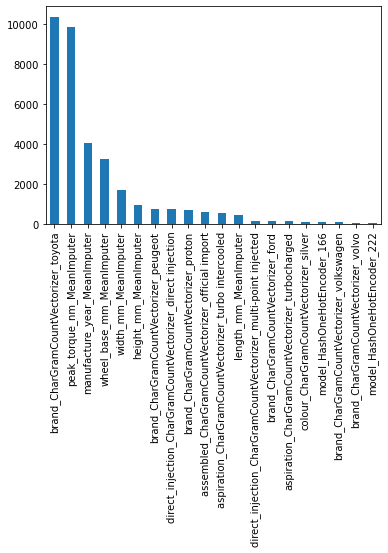

In [20]:
cols = [f'fi_{i}' for i in range(len(engineered_local_fi))]
pd_eng = pd.DataFrame(np.array(engineered_local_fi).T, index=engineered_feature_names, columns=cols)
pd_eng = pd_eng['fi_0'].sort_values(ascending=False).head(20)
pd_eng.plot.bar()

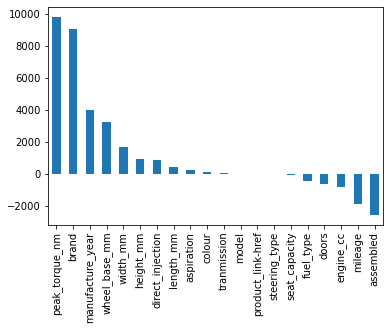

In [21]:
cols = [f'fi_{i}' for i in range(len(raw_local_fi))]
pd_raw = pd.DataFrame(np.array(raw_local_fi).T, index=raw_feature_names, columns=cols)
pd_raw = pd_raw['fi_0'].sort_values(ascending=False).head(20)
pd_raw.plot.bar()